In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier


### read the two data files
athlete_data = pd.read_csv('athlete_events.csv', names= ["ID","Name","Sex","Age","Height","Weight","Team","NOC","Games","Year","Season","City","Sport","Event","Medal"])

NOC_data = pd.read_csv('noc_regions.csv', names= ["NOC","region","notes"])

### inspect the datasets
print(athlete_data.head())
print('#########################')
print(NOC_data.head())


### Drop the notes column and change the name og column region
NOC_data.drop('notes', axis = 1, inplace =True)
NOC_data.rename(columns={"region": "Country"}, inplace = True)





   ID                      Name Sex   Age  Height  Weight            Team  \
0   1                 A Dijiang   M  24.0   180.0    80.0           China   
1   2                  A Lamusi   M  23.0   170.0    60.0           China   
2   3       Gunnar Nielsen Aaby   M  24.0     NaN     NaN         Denmark   
3   4      Edgar Lindenau Aabye   M  34.0     NaN     NaN  Denmark/Sweden   
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0     Netherlands   

   NOC        Games  Year  Season       City          Sport  \
0  CHN  1992 Summer  1992  Summer  Barcelona     Basketball   
1  CHN  2012 Summer  2012  Summer     London           Judo   
2  DEN  1920 Summer  1920  Summer  Antwerpen       Football   
3  DEN  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4  NED  1988 Winter  1988  Winter    Calgary  Speed Skating   

                              Event Medal  
0       Basketball Men's Basketball   NaN  
1      Judo Men's Extra-Lightweight   NaN  
2           Football Men's

In [20]:
athlete_data.describe()

,ID,Age,Height,Weight,Year
count,271116.000000,261642.000000,210945.000000,208241.000000,271116.000000
mean,68248.954396,25.556898,175.338970,70.702393,1978.378480
std,39022.286345,6.393561,10.518462,14.348020,29.877632
min,1.000000,10.000000,127.000000,25.000000,1896.000000
25%,34643.000000,21.000000,168.000000,60.000000,1960.000000
50%,68205.000000,24.000000,175.000000,70.000000,1988.000000
75%,102097.250000,28.000000,183.000000,79.000000,2002.000000
max,135571.000000,97.000000,226.000000,214.000000,2016.000000


In [21]:
### merge the two datasets 
olympic_data = athlete_data.merge(NOC_data, how = 'left', left_on = 'NOC', right_on = 'NOC')
print(olympic_data)

            ID                                Name Sex   Age  Height  Weight  \
0            1                           A Dijiang   M  24.0   180.0    80.0   
1            2                            A Lamusi   M  23.0   170.0    60.0   
2            3                 Gunnar Nielsen Aaby   M  24.0     NaN     NaN   
3            4                Edgar Lindenau Aabye   M  34.0     NaN     NaN   
4            5            Christine Jacoba Aaftink   F  21.0   185.0    82.0   
5            5            Christine Jacoba Aaftink   F  21.0   185.0    82.0   
6            5            Christine Jacoba Aaftink   F  25.0   185.0    82.0   
7            5            Christine Jacoba Aaftink   F  25.0   185.0    82.0   
8            5            Christine Jacoba Aaftink   F  27.0   185.0    82.0   
9            5            Christine Jacoba Aaftink   F  27.0   185.0    82.0   
10           6                     Per Knut Aaland   M  31.0   188.0    75.0   
11           6                     Per K

In [22]:

### Check the missing data
olympic_data.isnull().sum()


ID              0
Name            0
Sex             0
Age          9474
Height      60171
Weight      62875
Team            0
NOC             0
Games           0
Year            0
Season          0
City            0
Sport           0
Event           0
Medal      231333
Country       370
dtype: int64

In [23]:
## replace Nan value of medals with string 'no medal'

olympic_data['Medal'].fillna('No medal', inplace=True)
olympic_data.isnull().sum()


ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal          0
Country      370
dtype: int64

In [24]:
## the NOC and team of the missing countries name
olympic_data.loc[olympic_data['Country'].isnull(),['NOC', 'Team']].drop_duplicates()


,NOC,Team
578,SGP,Singapore
6267,ROT,Refugee Olympic Athletes
44376,SGP,June Climene
61080,UNK,Unknown
64674,TUV,Tuvalu
80986,SGP,Rika II
108582,SGP,Singapore-2
235895,SGP,Singapore-1


In [25]:
#### insert the missing countries manually based on NOC code

olympic_data.loc[olympic_data.Team == 'Refugee Olympic Athletes', 'Country'] = "Refugee Olympic Athletes"
olympic_data.loc[olympic_data.Team == 'Tuvalu', 'Country'] = "Tuvalu"
olympic_data.loc[olympic_data.Team == 'Unknown', 'Country'] = "Unknown"
olympic_data.loc[olympic_data.Team == 'Singapore', 'Country'] = "Singapore"
olympic_data.loc[olympic_data.Team == 'June Climene', 'Country'] = "Singapore"
olympic_data.loc[olympic_data.Team == 'Rika II', 'Country'] = "Singapore"
olympic_data.loc[olympic_data.Team == 'Singapore-2', 'Country'] = "Singapore"
olympic_data.loc[olympic_data.Team == 'Singapore-1', 'Country'] = "Singapore"

In [26]:

print(olympic_data.loc[olympic_data['Country'].isnull(),['NOC', 'Team']].drop_duplicates())
olympic_data.isnull().sum()

Empty DataFrame
Columns: [NOC, Team]
Index: []


ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal          0
Country        0
dtype: int64

In [27]:
## find the mean of the athlete's age based on sex and the sports they play and filling the missing age values by the mean of ages
mean_ages = round(olympic_data.groupby(['Sport','Sex'])['Age'].median().unstack())
#print(mean_ages)

def f_age_fixer(df, dic, sex):
    for k,v in dic.items():
        df.loc[(df['Age'].isnull()) & (df['Sex'] == sex) & (df['Sport'] == str(k)), 'Age'] = v
    return df

f_age = mean_ages.to_dict()['F']
#print(f_age)
m_age = mean_ages.to_dict()['M']

f_age_fixer(olympic_data, f_age, 'F')
f_age_fixer(olympic_data, m_age, 'M')



,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,No medal,China
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,No medal,China
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,No medal,Denmark
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,No medal,Netherlands
5,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",No medal,Netherlands
6,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,Speed Skating Women's 500 metres,No medal,Netherlands
7,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,"Speed Skating Women's 1,000 metres",No medal,Netherlands
8,5,Christine Jacoba Aaftink,F,27.0,185.0,82.0,Netherlands,NED,1994 Winter,1994,Winter,Lillehammer,Speed Skating,Speed Skating Women's 500 metres,No medal,Netherlands
9,5,Christine Jacoba Aaftink,F,27.0,185.0,82.0,Netherlands,NED,1994 Winter,1994,Winter,Lillehammer,Speed Skating,"Speed Skating Women's 1,000 metres",No medal,Netherlands


In [28]:
olympic_data.isnull().sum()

ID             0
Name           0
Sex            0
Age            0
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal          0
Country        0
dtype: int64

In [29]:
## find the mean of the athlete's height based on sex and the sports they play and filling the missing height values by the mean of heights

mean_heights = round(olympic_data.groupby(['Sport','Sex'])['Height'].mean().unstack())
#print(mean_heights)

def f_height_fixer(df, dic, sex):
    for k,v in dic.items():
        df.loc[(df['Height'].isnull()) & (df['Sex'] == sex) & (df['Sport'] == str(k)), 'Height'] = v
    return df

f_height = mean_heights.to_dict()['F']
#print(f_height)
m_height = mean_heights.to_dict()['M']

f_height_fixer(olympic_data, f_height, 'F')
f_height_fixer(olympic_data, m_height, 'M')




,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,No medal,China
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,No medal,China
2,3,Gunnar Nielsen Aaby,M,24.0,177.0,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,No medal,Denmark
3,4,Edgar Lindenau Aabye,M,34.0,182.0,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,No medal,Netherlands
5,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",No medal,Netherlands
6,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,Speed Skating Women's 500 metres,No medal,Netherlands
7,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,"Speed Skating Women's 1,000 metres",No medal,Netherlands
8,5,Christine Jacoba Aaftink,F,27.0,185.0,82.0,Netherlands,NED,1994 Winter,1994,Winter,Lillehammer,Speed Skating,Speed Skating Women's 500 metres,No medal,Netherlands
9,5,Christine Jacoba Aaftink,F,27.0,185.0,82.0,Netherlands,NED,1994 Winter,1994,Winter,Lillehammer,Speed Skating,"Speed Skating Women's 1,000 metres",No medal,Netherlands


In [30]:
olympic_data.isnull().sum()

ID             0
Name           0
Sex            0
Age            0
Height       100
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal          0
Country        0
dtype: int64

In [31]:
## find the mean of the athlete's weight based on sex and the sports they play and filling the missing weight values by the mean of weight
mean_weights = round(olympic_data.groupby(['Sport','Sex'])['Weight'].mean().unstack())
#print(mean_weights)

def f_weights_fixer(df, dic, sex):
    for k,v in dic.items():
        df.loc[(df['Weight'].isnull()) & (df['Sex'] == sex) & (df['Sport'] == str(k)), 'Weight'] = v
    return df

f_weights = mean_weights.to_dict()['F']
#print(f_weights)
m_weights = mean_weights.to_dict()['M']

f_weights_fixer(olympic_data, f_weights, 'F')
f_weights_fixer(olympic_data, m_weights, 'M')



,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,No medal,China
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,No medal,China
2,3,Gunnar Nielsen Aaby,M,24.0,177.0,73.0,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,No medal,Denmark
3,4,Edgar Lindenau Aabye,M,34.0,182.0,96.0,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,No medal,Netherlands
5,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",No medal,Netherlands
6,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,Speed Skating Women's 500 metres,No medal,Netherlands
7,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,"Speed Skating Women's 1,000 metres",No medal,Netherlands
8,5,Christine Jacoba Aaftink,F,27.0,185.0,82.0,Netherlands,NED,1994 Winter,1994,Winter,Lillehammer,Speed Skating,Speed Skating Women's 500 metres,No medal,Netherlands
9,5,Christine Jacoba Aaftink,F,27.0,185.0,82.0,Netherlands,NED,1994 Winter,1994,Winter,Lillehammer,Speed Skating,"Speed Skating Women's 1,000 metres",No medal,Netherlands


In [32]:
olympic_data.isnull().sum()

ID           0
Name         0
Sex          0
Age          0
Height     100
Weight     595
Team         0
NOC          0
Games        0
Year         0
Season       0
City         0
Sport        0
Event        0
Medal        0
Country      0
dtype: int64

In [33]:
## dropped 594 the remaining rows


olympic_data.replace(["NaN"], np.nan, inplace = True)
olympic_data.dropna(inplace=True)
print(olympic_data.shape)


(270521, 16)


In [34]:
olympic_data.isnull().sum()

ID         0
Name       0
Sex        0
Age        0
Height     0
Weight     0
Team       0
NOC        0
Games      0
Year       0
Season     0
City       0
Sport      0
Event      0
Medal      0
Country    0
dtype: int64

In [35]:
## the dataset and it's size after cleaning 

print(olympic_data.head())
print(olympic_data.shape)



   ID                      Name Sex   Age  Height  Weight            Team  \
0   1                 A Dijiang   M  24.0   180.0    80.0           China   
1   2                  A Lamusi   M  23.0   170.0    60.0           China   
2   3       Gunnar Nielsen Aaby   M  24.0   177.0    73.0         Denmark   
3   4      Edgar Lindenau Aabye   M  34.0   182.0    96.0  Denmark/Sweden   
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0     Netherlands   

   NOC        Games  Year  Season       City          Sport  \
0  CHN  1992 Summer  1992  Summer  Barcelona     Basketball   
1  CHN  2012 Summer  2012  Summer     London           Judo   
2  DEN  1920 Summer  1920  Summer  Antwerpen       Football   
3  DEN  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4  NED  1988 Winter  1988  Winter    Calgary  Speed Skating   

                              Event     Medal      Country  
0       Basketball Men's Basketball  No medal        China  
1      Judo Men's Extra-Lightweight 

In [36]:
### the number of of summer and winter sports after cleaning the dataset

print('Winter sport =' , len(olympic_data.loc[olympic_data['Season']=='Winter'].Sport.unique()))
print('Summer sport =' , len(olympic_data.loc[olympic_data['Season']=='Summer'].Sport.unique()))


Winter sport = 15
Summer sport = 43


In [37]:
### perform classification decision/tree algorithm to predict the suitable sport to the athletes based on their ages, heights and weights


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

### drop the unused columns
predict_sport = olympic_data.drop(['ID', 'Name',  'NOC', 'Games','City','Event','Medal','Team' ], axis = 1)
print(predict_sport.head())


###  choose the summer sport for males only 
predict_sport = predict_sport[(predict_sport['Season'] == 'Summer') &  (predict_sport['Sex'] == 'M')].drop_duplicates()
print(predict_sport.head())

print(len(predict_sport['Sport'].unique()))


### split the dataset to training and testing datasets
features = predict_sport.iloc[:,1:4].values
labels = predict_sport.iloc[:,6].values

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3, random_state= 0)


### scale the dataset 
feature_scaler = StandardScaler()

train_features = feature_scaler.fit_transform(train_features)
test_features = feature_scaler.transform(test_features)

### perform the decision tree algorithm to build the model on training dataset
dt_clf =  DecisionTreeClassifier(random_state=0)
dt_clf.fit(train_features, train_labels)

### predict the athlete's sport using testing set
predictions = dt_clf.predict(test_features)

comparison = pd.DataFrame({'Real':test_labels, 'Predictions': predictions})
print(comparison)


## find accuracy and confusion matrix 

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(test_labels, predictions))
print(classification_report(test_labels, predictions))
print("accuracy_score" , accuracy_score(test_labels, predictions))
print( )

  Sex   Age  Height  Weight  Year  Season          Sport      Country
0   M  24.0   180.0    80.0  1992  Summer     Basketball        China
1   M  23.0   170.0    60.0  2012  Summer           Judo        China
2   M  24.0   177.0    73.0  1920  Summer       Football      Denmark
3   M  34.0   182.0    96.0  1900  Summer     Tug-Of-War      Denmark
4   F  21.0   185.0    82.0  1988  Winter  Speed Skating  Netherlands
   Sex   Age  Height  Weight  Year  Season       Sport  Country
0    M  24.0   180.0    80.0  1992  Summer  Basketball    China
1    M  23.0   170.0    60.0  2012  Summer        Judo    China
2    M  24.0   177.0    73.0  1920  Summer    Football  Denmark
3    M  34.0   182.0    96.0  1900  Summer  Tug-Of-War  Denmark
29   M  26.0   184.0    78.0  1952  Summer    Swimming  Finland
40
                    Real        Predictions
0             Water Polo         Water Polo
1               Canoeing          Athletics
2              Athletics          Athletics
3                

C:\Users\Soona\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


                   precision    recall  f1-score   support

          Archery       0.13      0.18      0.15       231
 Art Competitions       0.81      0.96      0.88       346
        Athletics       0.35      0.58      0.44      5984
        Badminton       0.02      0.02      0.02       183
         Baseball       0.03      0.04      0.04       256
       Basketball       0.35      0.38      0.37       913
 Beach Volleyball       0.04      0.05      0.04        79
           Boxing       0.37      0.42      0.39      1629
         Canoeing       0.17      0.17      0.17      1103
          Cycling       0.26      0.23      0.25      1763
           Diving       0.38      0.31      0.34       334
    Equestrianism       0.44      0.39      0.41       814
          Fencing       0.38      0.35      0.37      1276
   Figure Skating       0.23      0.50      0.32         6
         Football       0.32      0.33      0.32      1384
             Golf       0.14      0.12      0.13       

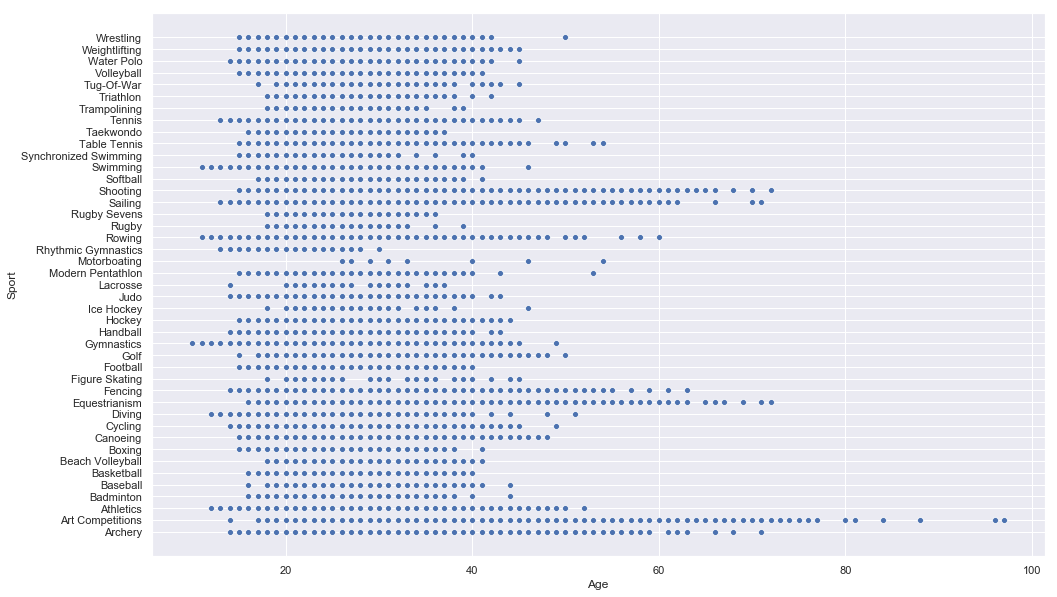

In [38]:
#### plot the ages range of competitors in all summer sports

import seaborn as sns
plt.figure(figsize=(16, 10))
sns.set(style="darkgrid")

age_sport = olympic_data[olympic_data['Season']=='Summer'].groupby(['Sport','Age'])['ID'].nunique().reset_index()
#print(age_sport)
ax = sns.scatterplot(x='Age' , y='Sport', data=age_sport)

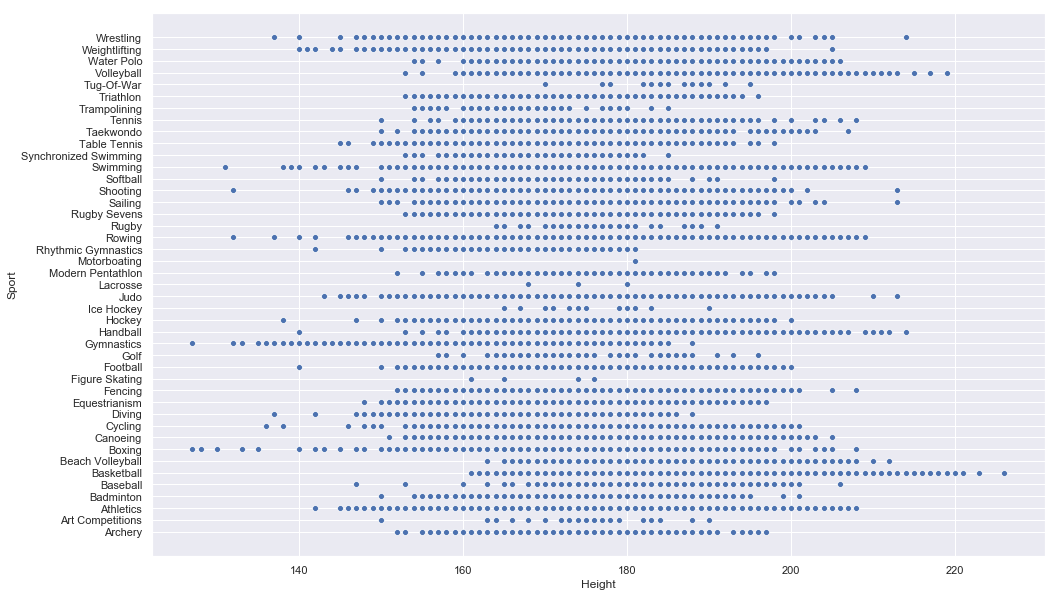

In [39]:
#### plot the heights range of competitors in all summer sports

import seaborn as sns
plt.figure(figsize=(16, 10))
sns.set(style="darkgrid")

height_sport = olympic_data[olympic_data['Season']=='Summer'].groupby(['Sport','Height'])['ID'].nunique().reset_index()
#print(height_sport)
ax = sns.scatterplot(x='Height' , y='Sport', data=height_sport)

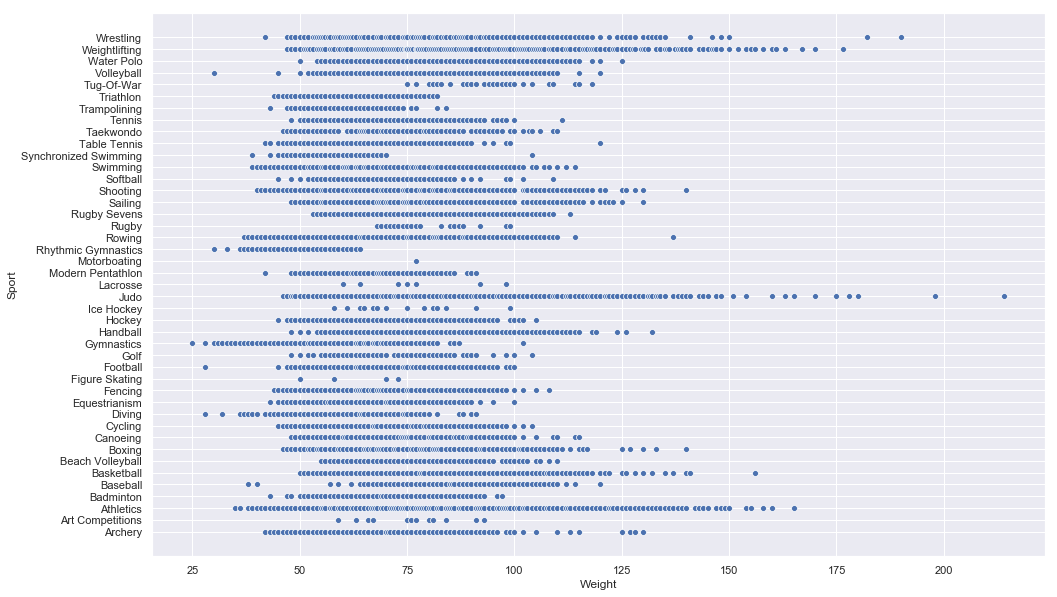

In [40]:
### #### plot the weights range of competitors in all summer sports

import seaborn as sns
plt.figure(figsize=(16, 10))
sns.set(style="darkgrid")

weight_sport = olympic_data[olympic_data['Season']=='Summer'].groupby(['Sport','Weight'])['ID'].nunique().reset_index()
#print(weight_sport)
ax = sns.scatterplot(x='Weight' , y='Sport', data=weight_sport)

         Age  Height  Weight          Sport
0       24.0   180.0    80.0     Basketball
57      31.0   189.0   130.0      Athletics
94      24.0   174.0    70.0      Athletics
95      23.0   180.0    74.0      Athletics
98      30.0   187.0    76.0      Athletics
130     22.0   177.0    74.0      Athletics
132     26.0   177.0    74.0      Athletics
133     30.0   177.0    74.0      Athletics
134     24.0   173.0    64.0         Boxing
145     22.0   189.0    80.0      Athletics
147     23.0   173.0    65.0         Boxing
148     26.0   170.0    65.0      Athletics
151     24.0   176.0    66.0         Boxing
154     24.0   164.0    71.0  Weightlifting
155     28.0   164.0    71.0  Weightlifting
156     24.0   172.0    75.0  Weightlifting
162     23.0   156.0    48.0         Boxing
179     27.0   166.0    75.0         Boxing
181     23.0   173.0    65.0         Boxing
190     22.0   182.0    67.0      Athletics
191     26.0   182.0    67.0      Athletics
197     27.0   190.0    80.0    

C:\Users\Soona\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


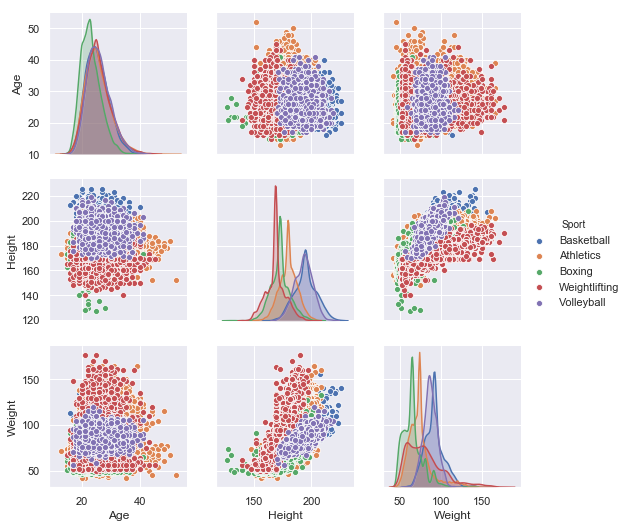

               Real    Predictions
0         Athletics      Athletics
1         Athletics      Athletics
2         Athletics  Weightlifting
3         Athletics      Athletics
4         Athletics      Athletics
5        Basketball      Athletics
6         Athletics      Athletics
7     Weightlifting  Weightlifting
8            Boxing         Boxing
9         Athletics      Athletics
10    Weightlifting  Weightlifting
11        Athletics      Athletics
12           Boxing         Boxing
13           Boxing      Athletics
14        Athletics      Athletics
15    Weightlifting  Weightlifting
16       Basketball     Basketball
17        Athletics      Athletics
18        Athletics      Athletics
19        Athletics      Athletics
20           Boxing         Boxing
21        Athletics      Athletics
22       Basketball     Volleyball
23        Athletics      Athletics
24           Boxing      Athletics
25       Basketball      Athletics
26           Boxing         Boxing
27        Athletics 

In [41]:
### perform classification tree decision algorithm to predict 5 different sports to the athletes based on their ages, heights and weights


predict_sport = predict_sport.drop(['Sex', 'Year',  'Season', 'Country'], axis = 1)

### choose the 5 sports to be predicted 
predict_sport = predict_sport[predict_sport['Sport'].isin(['Weightlifting', 'Athletics', 'Basketball','Boxing', 'Volleyball'])]
print(predict_sport)


### plot the pairplot for the dataset to find the classification sports
sns.pairplot(predict_sport, hue='Sport')
plt.show()

### split the dataset to training and testing datasets
features = predict_sport.iloc[:,0:3].values
labels = predict_sport.iloc[:,3].values

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3, random_state= 42)


### scale the dataset
feature_scaler = StandardScaler()

train_features = feature_scaler.fit_transform(train_features)
test_features = feature_scaler.transform(test_features)


### perform the decision tree algorithm to build the model on training dataset
dt_clf =  DecisionTreeClassifier(random_state=0)
dt_clf.fit(train_features, train_labels)

### predict the sports using the testing dataset
predictions = dt_clf.predict(test_features)


comparison = pd.DataFrame({'Real':test_labels, 'Predictions': predictions})
print(comparison)


## find accuracy and confusion matrix (Sullivan,2017)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(test_labels, predictions))
print(classification_report(test_labels, predictions))
print("accuracy_score" , accuracy_score(test_labels, predictions))
print( )

In [42]:
### read the check the population dataset for  all countries

pop_data = pd.read_csv('WorldPopulation.csv')

pop_data.drop(columns=['Indicator Name', 'Indicator Code', 'Unnamed: 61'], inplace = True)
pop_data.head()


population = pd.melt(pop_data, id_vars = ['Country', 'Country Code'], var_name = 'Year', value_name = 'Population')

population['year']= population['Year'].astype(int)
population.drop(['Year'], axis = 1, inplace=True)
population.head()
#print(population[population['Country']=='China'])

,Country,Country Code,Population,year
0,Aruba,ABW,54211.0,1960
1,Afghanistan,AFG,8996351.0,1960
2,Angola,AGO,5643182.0,1960
3,Albania,ALB,1608800.0,1960
4,Andorra,AND,13411.0,1960


In [43]:
### read the GDP dataset for the countries

GDP_data = pd.read_csv('w_gdp.csv', encoding='latin-1')

GDP_data.drop(columns=['Indicator Name', 'Indicator Code'], inplace = True)
GDP_data.head()

GDP = pd.melt(GDP_data, id_vars = ['Country Name', 'Country Code'], var_name = 'Year', value_name = 'GDP')
GDP['year']= GDP['Year'].astype(int)
GDP.drop(['Year'], axis = 1, inplace=True)
GDP.head()

,Country Name,Country Code,GDP,year
0,Afghanistan,AFG,5.377778e+08,1960
1,Albania,ALB,NaN,1960
2,Algeria,DZA,2.723649e+09,1960
3,American Samoa,ASM,NaN,1960
4,Andorra,AND,NaN,1960


In [44]:
#### merge the population dataset with olympics dataset and drop the common columns


olympic_data_merge = olympic_data.merge(population, how = 'left', left_on = ['Country', 'Year'], right_on = ['Country','year'])
olympic_data_merge.drop(columns=['Country Code', 'year'], inplace = True)
olympic_data_merge.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country,Population
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,No medal,China,1.164970e+09
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,No medal,China,1.350695e+09
2,3,Gunnar Nielsen Aaby,M,24.0,177.0,73.0,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,No medal,Denmark,NaN
3,4,Edgar Lindenau Aabye,M,34.0,182.0,96.0,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,No medal,Netherlands,1.476009e+07


In [45]:
olympic_data_merge.isnull().sum()

ID                0
Name              0
Sex               0
Age               0
Height            0
Weight            0
Team              0
NOC               0
Games             0
Year              0
Season            0
City              0
Sport             0
Event             0
Medal             0
Country           0
Population    74226
dtype: int64

In [46]:
#### merge the GDP dataset with olympics dataset and drop the common columns

olympic_data_merge = olympic_data_merge.merge(GDP, how = 'left', left_on = ['NOC', 'Year'], right_on = ['Country Code', 'year'])
olympic_data_merge.drop(columns=['Country Name', 'Country Code', 'year'], inplace = True)

olympic_data_merge.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country,Population,GDP
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,No medal,China,1.164970e+09,4.269157e+11
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,No medal,China,1.350695e+09,8.560547e+12
2,3,Gunnar Nielsen Aaby,M,24.0,177.0,73.0,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,No medal,Denmark,NaN,NaN
3,4,Edgar Lindenau Aabye,M,34.0,182.0,96.0,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,NaN,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,No medal,Netherlands,1.476009e+07,NaN


In [47]:

print(olympic_data_merge.shape)
olympic_data_merge.isnull().sum()



(270521, 18)


ID                 0
Name               0
Sex                0
Age                0
Height             0
Weight             0
Team               0
NOC                0
Games              0
Year               0
Season             0
City               0
Sport              0
Event              0
Medal              0
Country            0
Population     74226
GDP           128296
dtype: int64

In [48]:
### drop the rows with missing values of population and Gdp

olympic_data_merge.replace(["NaN"], np.nan, inplace = True)
olympic_data_merge.dropna(inplace=True)
olympic_data_merge.shape

(134725, 18)

In [49]:
## create a column that convert each medal to 1 and if no medal then 0
olympic_data_merge['medal_won']  = np.where(olympic_data_merge.loc[:,'Medal'] == 'No medal', 0, 1)
#print(olympic_data_merge.head())


### find the total medals that were won for each country in each year when the olympics are held
data = olympic_data_merge.groupby(['Country', 'Year'], as_index=False)['medal_won'].agg(sum)

data = pd.DataFrame(data).sort_values(by = ['medal_won'] ,ascending= False)
print(data)

### merge the GDP values with dataset that has the number of medals of each country

GDP_df = olympic_data_merge.filter(['Country', 'Year', 'GDP'], axis=1).drop_duplicates()

GDP_df = GDP_df.merge(data, how = 'inner').sort_values(by = ['Year','medal_won'] ,ascending= False)
print(GDP_df)


            Country  Year  medal_won
1268            USA  1984        361
1278            USA  2008        317
1282            USA  2016        264
1276            USA  2004        263
1272            USA  1996        259
1280            USA  2012        248
1274            USA  2000        242
1270            USA  1992        238
1269            USA  1988        214
1265            USA  1972        195
1028         Russia  2004        189
1026         Russia  2000        187
280           China  2008        184
80        Australia  2000        183
1263            USA  1964        177
1266            USA  1976        175
1264            USA  1968        173
82        Australia  2004        157
1262            USA  1960        152
84        Australia  2008        149
1261             UK  2016        145
1030         Russia  2008        142
1032         Russia  2012        140
78        Australia  1996        132
282           China  2012        126
1259             UK  2012        126
1

In [50]:
### merge the population values for each country with the dataset that has the number of medals of each country

population_df = olympic_data_merge.filter(['Country', 'Year', 'Population'], axis=1).drop_duplicates()

#print(GDP_df[GDP_df['Country']=='USA'])
population_df = population_df.merge(GDP_df, how = 'inner').sort_values(by = ['Year','medal_won'] ,ascending= False)
print(population_df.head())

    Country  Year    Population           GDP  medal_won
96      USA  2016  3.231275e+08  1.862448e+13        264
345      UK  2016  6.563724e+07  2.647899e+12        145
147  Russia  2016  1.443424e+08  1.283163e+12        115
488   China  2016  1.378665e+09  1.119915e+13        113
489   China  2016  1.378665e+09  3.209143e+11        113


In [51]:
### preform linear regression algorithm to predict the total of win medals for a country according to its population and GDP values 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score


features = population_df[['GDP','Population']]
labels = population_df['medal_won']

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state= 0)


feature_scaler = StandardScaler()

train_features = feature_scaler.fit_transform(train_features)
test_features = feature_scaler.transform(test_features)

lin_reg = LinearRegression()

lin_reg.fit(train_features, train_labels)
coefficients = pd.DataFrame(lin_reg.coef_, features.columns, columns=['Coefficients'])
print(coefficients)


predictions = lin_reg.predict(test_features)
comparision = pd.DataFrame({'Real':test_labels,'predictions': predictions})
print(comparision)

print(r2_score(test_labels, predictions, multioutput='variance_weighted'))

print('MAE:', metrics.mean_absolute_error(test_labels, predictions))
print('MSE:', metrics.mean_squared_error(test_labels, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_labels, predictions)))



            Coefficients
GDP            16.431504
Population      3.912623
      Real  predictions
346     52    10.151972
948      0     9.020213
1213     0     8.083549
1244     0     7.751187
244      0     7.707960
1310     0     8.444113
695     16    33.517097
733      0     7.961906
1084     0     8.128461
683      0     8.445442
1085     0     7.866702
670      0    12.442271
151     59    13.246222
162     93    64.123721
535      0     8.058639
137      0     8.839962
1025     0     7.701703
1239     0     7.728357
625     16     9.126711
1217     1     7.919960
493     17     7.927370
739      5     8.814190
684      0     7.704686
49      96    36.612547
877     12   150.870139
146      1     7.930752
359      8    18.871231
994      4     7.775032
847     52    28.974770
700      1     8.283856
...    ...          ...
1303     0     7.803710
674      0     7.710878
452      2     9.860352
1215     0     7.696070
839      0     7.796202
786      0     9.941371
883      0   

In [52]:
### preform polynomial regression algorithm to predict the total of win medals for a country according to its population and GDP values 



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score

features = population_df.iloc[:,2:4].values
labels = population_df.iloc[:,4].values


train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state= 0)
#print(train_labels.shape)
from sklearn.preprocessing import PolynomialFeatures
#
poly_reg_features = PolynomialFeatures(degree =2)
train_features_poly = poly_reg_features.fit_transform(train_features)
test_features_poly = poly_reg_features.transform(test_features) 


feature_scaler = StandardScaler()
train_features_poly = feature_scaler.fit_transform(train_features_poly)
test_features_poly = feature_scaler.transform(test_features_poly)

lin_reg = LinearRegression()

lin_reg.fit(train_features_poly, train_labels)

predictions = lin_reg.predict(test_features_poly)
comparision = pd.DataFrame({'Real':test_labels,'predictions': predictions})
print(comparision)

print(r2_score(test_labels, predictions, multioutput='variance_weighted'))
print('MAE:', metrics.mean_absolute_error(test_labels, predictions))
print('MSE:', metrics.mean_squared_error(test_labels, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_labels, predictions)))



     Real  predictions
0      52     9.659664
1       0     7.225318
2       0     6.024729
3       0     4.993520
4       0     4.969414
5       0     6.107821
6      16    21.328846
7       0     5.487302
8       0     6.542949
9       0     7.465604
10      0     5.667420
11      0    12.750728
12     59    19.320790
13     93    86.516535
14      0     6.474481
15      0     6.913838
16      0     4.935873
17      0     4.960387
18     16    11.050498
19      1     5.891129
20     17     5.704799
21      5     7.246386
22      0     4.960350
23     96    50.436959
24     12   115.711656
25      1     5.800877
26      8    26.357011
27      4     5.178753
28     52    29.987906
29      1     6.404751
..    ...          ...
237     0     5.416262
238     0     4.929947
239     2    11.860815
240     0     4.909398
241     0     5.322369
242     0     8.646640
243     0     5.507658
244     0     4.952693
245     0     6.935936
246     0     5.319891
247    85    32.507165
248     0  